# RES Generation Model Training

This notebook implements XGBoost model training for RES generation forecasting:
- Loads processed RES generation data
- Prepares features and target variables
- Splits data into training and validation sets
- Implements XGBoost model training for RES generation forecasting
- Evaluates model performance on validation data
- Saves the trained model
- Generates future RES generation predictions for 2025-2029
- Creates performance visualizations


In [52]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
RES Generation Forecasting Model Training Script
This script trains an XGBoost model for renewable energy generation forecasting using the processed and analyzed RES data.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from pathlib import Path
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 6)

# Define paths - relative to script location
# Define paths
BASE_DIR = Path().resolve().parent
DATA_DIR = BASE_DIR / 'data/final/Italy'
MODELS_DIR = BASE_DIR / 'models'
IMAGES_DIR = BASE_DIR / 'outputs/images'
OUTPUT_DIR = BASE_DIR / 'outputs'

# Create output directories
for directory in [MODELS_DIR, IMAGES_DIR, OUTPUT_DIR]:
    os.makedirs(directory, exist_ok=True)




In [53]:
def load_data():
    """Load the processed RES data with engineered features"""
    print("Loading processed RES generation data...")
    
    # Try to load the train/test datasets created by the EDA script
    train_data = pd.read_csv(DATA_DIR / 'res_train_data.csv')
    test_data = pd.read_csv(DATA_DIR / 'res_test_data.csv')
    
    # Convert date column to datetime
    train_data['date'] = pd.to_datetime(train_data['date'])
    test_data['date'] = pd.to_datetime(test_data['date'])
    
    print(f"Successfully loaded training data: {train_data.shape[0]} rows")
    print(f"Successfully loaded testing data: {test_data.shape[0]} rows")
    
    return train_data, test_data

def prepare_features_target(train_data, test_data):
    """Prepare features and target variables for modeling"""
    print("Preparing features and target variables...")
    
    # Define features to use
    features = [
        'dayofweek', 'month', 'quarter', 'year', 'dayofyear', 'is_weekend',
        'total_res_mw_lag1', 'total_res_mw_lag7', 'total_res_mw_lag30',
        'total_res_mw_rolling_7d_mean', 'total_res_mw_rolling_30d_mean',
        'total_res_mw_rolling_7d_std', 'total_res_mw_rolling_30d_std',
        'price_eur_mwh'
    ]
    
    # Ensure all features exist in the dataframes
    features_to_remove = []
    for feature in features:
        if feature not in train_data.columns:
            print(f"Warning: Feature '{feature}' not found in training data. Will be removed from feature list.")
            features_to_remove.append(feature)
        elif feature not in test_data.columns:
            print(f"Warning: Feature '{feature}' not found in test data. Will be removed from feature list.")
            if feature not in features_to_remove:
                features_to_remove.append(feature)

    for feature in features_to_remove:
        features.remove(feature)

    if not features:
        raise ValueError("No features selected or available in the data. Halting.")

    print(f"Attempting to use features: {features}")
    
    # Save feature list for future use
    joblib.dump(features, MODELS_DIR / 'res_features.joblib')
    
    # Prepare training data
    X_train = train_data[features]
    y_train = train_data['total_res_mw']
    
    # Prepare testing data
    X_test = test_data[features]
    y_test = test_data['total_res_mw']
    
    print(f"Features used: {features}")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    
    return X_train, y_train, X_test, y_test, features

def train_model(X_train, y_train, X_test, y_test):
    """Train XGBoost model for RES generation forecasting"""
    print("Training XGBoost model...")
    
    # Define XGBoost model parameters
    model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        eval_metric='rmse',
        early_stopping_rounds=50,
        random_state=42
    )
    
    # Train the model with early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=True
    )
    
    # Evaluate on test set
    test_score = model.score(X_test, y_test)
    print(f"Test R² score: {test_score:.4f}")
    
    # Save the model
    model_path = MODELS_DIR / 'energy_res_xgb_v1.joblib'
    joblib.dump(model, model_path)
    print(f"Model saved to {model_path}")
    
    return model

def evaluate_model(model, X_test, y_test, features):
    """Evaluate model performance on test data"""
    print("Evaluating model performance...")
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"RMSE: {rmse:.2f} MW")
    print(f"MAE: {mae:.2f} MW")
    print(f"R²: {r2:.4f}")
    
    # Create a dataframe with actual and predicted values
    results_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    })
    
    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(results_df.index, results_df['Actual'], label='Actual', color='blue')
    plt.plot(results_df.index, results_df['Predicted'], label='Predicted', color='red')
    plt.title('Actual vs Predicted RES Generation')
    plt.xlabel('Sample Index')
    plt.ylabel('RES Generation (MW)')
    plt.legend()
    plt.savefig(IMAGES_DIR / 'res_actual_vs_predicted.png', dpi=300)
    
    # Plot scatter of actual vs predicted
    plt.figure(figsize=(10, 10))
    plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title('Actual vs Predicted RES Generation')
    plt.xlabel('Actual RES Generation (MW)')
    plt.ylabel('Predicted RES Generation (MW)')
    plt.savefig(IMAGES_DIR / 'res_scatter_actual_vs_predicted.png', dpi=300)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    xgb.plot_importance(model, max_num_features=len(features))
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'res_feature_importance.png', dpi=300)
    
    return rmse, mae, r2

def load_price_forecasts():
    """Load the price forecasts for 2025-2029"""
    print("Loading price forecasts for 2025-2029...")
    
    try:
        price_forecasts = pd.read_csv(DATA_DIR / 'energy_price2025_2029.csv')
        price_forecasts['Date'] = pd.to_datetime(price_forecasts['Date'])
        print(f"Successfully loaded price forecasts: {price_forecasts.shape[0]} rows")
        return price_forecasts
    except FileNotFoundError:
        print("Price forecast file not found. Please ensure the file exists.")
        return None

def generate_future_predictions(model, features, price_forecasts):
    """
    Generate RES generation predictions for future dates using the trained model.
    
    Args:
        model: Trained XGBoost model
        features: List of features used by the model
        price_forecasts: DataFrame containing price forecasts for future dates
        
    Returns:
        DataFrame with future RES generation predictions
    """
    print("Generating future RES generation predictions for 2025-2029...")
    
    if price_forecasts is None:
        print("Error: Price forecasts not available. Cannot generate future predictions.")
        return None
    
    # Create a copy of the price forecasts dataframe
    future_df = price_forecasts.copy()
    
    # Ensure the date column is in datetime format
    future_df['Date'] = pd.to_datetime(future_df['Date'])
    future_df.set_index('Date', inplace=True)
    
    # Create time-based features
    future_df['dayofweek'] = future_df.index.dayofweek
    future_df['month'] = future_df.index.month
    future_df['quarter'] = future_df.index.quarter
    future_df['year'] = future_df.index.year
    future_df['dayofyear'] = future_df.index.dayofyear
    future_df['is_weekend'] = (future_df.index.dayofweek >= 5).astype(int)
    
    # Initialize lag features with NaN
    future_df['total_res_mw_lag1'] = np.nan
    future_df['total_res_mw_lag7'] = np.nan
    future_df['total_res_mw_lag30'] = np.nan
    future_df['total_res_mw_rolling_7d_mean'] = np.nan
    future_df['total_res_mw_rolling_30d_mean'] = np.nan
    future_df['total_res_mw_rolling_7d_std'] = np.nan
    future_df['total_res_mw_rolling_30d_std'] = np.nan
    
    # Load historical data to initialize lag features
    historical_data = pd.read_csv(os.path.join(DATA_DIR, "res_train_data.csv"))
    
    # Find date column
    date_col = None
    res_col = None
    
    # Find date column
    for col in historical_data.columns:
        if col.lower() in ['date', 'datetime', 'time']:
            date_col = col
            break
    
    # Find RES column
    for col in historical_data.columns:
        if col.lower() in ['total_res_mw', 'res_mw', 'res_generation']:
            res_col = col
            break
            
    if date_col is None or res_col is None:
        raise ValueError(f"Could not identify date or RES columns. Available columns: {historical_data.columns}")
        
    historical_data[date_col] = pd.to_datetime(historical_data[date_col])
    historical_data.set_index(date_col, inplace=True)
    historical_data = historical_data.sort_index()
    
    # Get the last 30 days of historical RES generation
    last_30_days = historical_data.tail(30)
    
    # Initialize lag values from historical data
    last_res = last_30_days[res_col].values
    
    # Set initial lag values for the first day in the future dataset
    future_df.iloc[0, future_df.columns.get_loc('total_res_mw_lag1')] = last_res[-1]
    future_df.iloc[0, future_df.columns.get_loc('total_res_mw_lag7')] = last_res[-7] if len(last_res) >= 7 else last_res[-1]
    future_df.iloc[0, future_df.columns.get_loc('total_res_mw_lag30')] = last_res[-30] if len(last_res) >= 30 else last_res[-1]
    
    # Set initial rolling statistics
    future_df.iloc[0, future_df.columns.get_loc('total_res_mw_rolling_7d_mean')] = np.mean(last_res[-7:])
    future_df.iloc[0, future_df.columns.get_loc('total_res_mw_rolling_30d_mean')] = np.mean(last_res)
    future_df.iloc[0, future_df.columns.get_loc('total_res_mw_rolling_7d_std')] = np.std(last_res[-7:])
    future_df.iloc[0, future_df.columns.get_loc('total_res_mw_rolling_30d_std')] = np.std(last_res)
    
    # Add a total_res_mw column to store predictions
    future_df['total_res_mw'] = np.nan
    
    # Iteratively predict each day
    for i in range(len(future_df)):
        # Get features for current prediction
        X_pred = future_df.iloc[i:i+1][features].copy()
        
        # Make prediction
        pred = model.predict(X_pred)[0]
        
        # Store prediction
        future_df.iloc[i, future_df.columns.get_loc('total_res_mw')] = pred
        
        # Update lag features for next day if not the last day
        if i < len(future_df) - 1:
            future_df.iloc[i+1, future_df.columns.get_loc('total_res_mw_lag1')] = pred
            
            # Update lag7 - either from prediction or from historical data
            if i >= 6:
                future_df.iloc[i+1, future_df.columns.get_loc('total_res_mw_lag7')] = future_df.iloc[i-6, future_df.columns.get_loc('total_res_mw')]
            
            # Update lag30 - either from prediction or from historical data
            if i >= 29:
                future_df.iloc[i+1, future_df.columns.get_loc('total_res_mw_lag30')] = future_df.iloc[i-29, future_df.columns.get_loc('total_res_mw')]
            
            # Update rolling statistics
            if i >= 6:
                last_7_days = future_df.iloc[i-6:i+1]['total_res_mw'].values
                future_df.iloc[i+1, future_df.columns.get_loc('total_res_mw_rolling_7d_mean')] = np.mean(last_7_days)
                future_df.iloc[i+1, future_df.columns.get_loc('total_res_mw_rolling_7d_std')] = np.std(last_7_days)
            
            if i >= 29:
                last_30_days = future_df.iloc[i-29:i+1]['total_res_mw'].values
                future_df.iloc[i+1, future_df.columns.get_loc('total_res_mw_rolling_30d_mean')] = np.mean(last_30_days)
                future_df.iloc[i+1, future_df.columns.get_loc('total_res_mw_rolling_30d_std')] = np.std(last_30_days)
        
        # Print progress
        if (i+1) % 100 == 0 or i == len(future_df) - 1:
            print(f"Progress: {i+1}/{len(future_df)} days processed")
    
    # Reset index to have Date as a column
    future_df = future_df.reset_index()
    
    # Save predictions
    output_path = os.path.join(DATA_DIR, "energy_res2025_2029.csv")
    
    # Check if 'price_eur_mwh' column exists
    if 'price_eur_mwh' in future_df.columns:
        future_df[['Date', 'total_res_mw', 'price_eur_mwh']].to_csv(output_path, index=False)
    else:
        # Look for alternative price column names
        price_cols = [col for col in future_df.columns if 'price' in col.lower()]
        if price_cols:
            # Use the first found price column
            future_df[['Date', 'total_res_mw', price_cols[0]]].to_csv(output_path, index=False)
            print(f"Used '{price_cols[0]}' as the price column")
        else:
            # Save without price column
            future_df[['Date', 'total_res_mw']].to_csv(output_path, index=False)
            print("Warning: No price column found in the data")
    
    print(f"Future RES generation predictions saved to {output_path}")
    
    return future_df

def analyze_correlations(historical_data, future_predictions):
    """
    Analyze correlations between energy price and RES generation in historical and future data.
    
    Args:
        historical_data: DataFrame with historical RES data (should include price)
        future_predictions: DataFrame with future RES predictions
    """
    print("Analyzing correlations between price and RES generation...")
    
    # Historical correlation
    try:
        # Find relevant columns in historical_data
        res_col_hist = None
        price_col_hist = None

        for col in historical_data.columns:
            if col.lower() in ['total_res_mw', 'res_mw', 'res_generation']:
                res_col_hist = col
                break
        
        for col in historical_data.columns:
            if 'price_eur_mwh' == col.lower():
                price_col_hist = col
                break
            elif 'price' in col.lower() and price_col_hist is None:
                price_col_hist = col

        if res_col_hist is None or price_col_hist is None:
            print(f"Could not identify RES or price columns in historical_data. Available columns: {historical_data.columns}")
            if price_col_hist is None:
                print("Price column not found in historical_data for correlation analysis.")
                raise KeyError("Price column for historical correlation not found in input historical_data.")

        # Calculate correlation directly from historical_data
        correlation = historical_data[res_col_hist].corr(historical_data[price_col_hist])
        print(f"Historical correlation between price and RES generation: {correlation:.4f}")
        
        # Create scatter plot
        plt.figure(figsize=(10, 6))
        plt.scatter(historical_data[price_col_hist], historical_data[res_col_hist], alpha=0.5)
        plt.title('Historical Price vs RES Generation Correlation')
        plt.xlabel('Price (EUR/MWh)')
        plt.ylabel('RES Generation (MW)')
        plt.grid(True)
        plt.savefig(os.path.join(IMAGES_DIR, 'historical_price_res_correlation.png'), dpi=300)
        
    except KeyError as ke:
        print(f"KeyError during historical correlation analysis: {ke}. Check column names in historical_data.")
    except Exception as e:
        print(f"Could not analyze historical correlation: {e}")
    
    # Future correlation
    try:
        # Find price column in future predictions
        price_col_future = None
        
        for col in future_predictions.columns:
            if 'price' in col.lower():
                price_col_future = col
                break
                
        if price_col_future is None:
            print("Could not identify price column in future predictions")
            return
            
        # Calculate correlation
        correlation = future_predictions['total_res_mw'].corr(future_predictions[price_col_future])
        print(f"Future correlation between price and RES generation: {correlation:.4f}")
        
        # Create scatter plot
        plt.figure(figsize=(10, 6))
        plt.scatter(future_predictions[price_col_future], future_predictions['total_res_mw'], alpha=0.5)
        plt.title('Future Price vs RES Generation Correlation (2025-2029)')
        plt.xlabel('Price (EUR/MWh)')
        plt.ylabel('RES Generation (MW)')
        plt.grid(True)
        plt.savefig(os.path.join(IMAGES_DIR, 'future_price_res_correlation.png'), dpi=300)
        
        # Monthly average RES generation by year
        future_predictions['Year'] = pd.to_datetime(future_predictions['Date']).dt.year
        future_predictions['Month'] = pd.to_datetime(future_predictions['Date']).dt.month
        
        monthly_avg = future_predictions.groupby(['Year', 'Month'])['total_res_mw'].mean().reset_index()
        
        plt.figure(figsize=(12, 6))
        for year in monthly_avg['Year'].unique():
            year_data = monthly_avg[monthly_avg['Year'] == year]
            plt.plot(year_data['Month'], year_data['total_res_mw'], marker='o', label=str(year))
        
        plt.title('Monthly Average RES Generation by Year (2025-2029)')
        plt.xlabel('Month')
        plt.ylabel('Average RES Generation (MW)')
        plt.grid(True)
        plt.legend()
        plt.xticks(range(1, 13))
        plt.savefig(os.path.join(IMAGES_DIR, 'monthly_avg_res_by_year.png'), dpi=300)
        
    except Exception as e:
        print(f"Could not analyze future correlation: {e}")

def plot_full_res_history_and_predictions(train_data_hist, test_data_hist, future_predictions_df):
    """
    Plot the full history of RES generation (training and test) and predicted future generation.
    
    Args:
        train_data_hist: DataFrame with historical training data (must include 'date' and 'total_res_mw')
        test_data_hist: DataFrame with historical test data (must include 'date' and 'total_res_mw')
        future_predictions_df: DataFrame with future RES predictions (must include 'Date' and 'total_res_mw')
    """
    print("Generating full RES generation history and predictions plot...")

    # Prepare training data for plot by explicitly creating a new DataFrame
    train_plot = pd.DataFrame({
        'Date': pd.to_datetime(train_data_hist['date']),
        'RES': train_data_hist['total_res_mw'],
        'Source': 'Training Data'
    })

    # Prepare test data for plot by explicitly creating a new DataFrame
    test_plot = pd.DataFrame({
        'Date': pd.to_datetime(test_data_hist['date']),
        'RES': test_data_hist['total_res_mw'],
        'Source': 'Test Data'
    })

    # Prepare future predictions for plot by explicitly creating a new DataFrame
    future_plot = pd.DataFrame({
        'Date': pd.to_datetime(future_predictions_df['Date']),
        'RES': future_predictions_df['total_res_mw'],
        'Source': 'Predicted (2025-2029)'
    })

    # Concatenate all data for plotting
    plot_data = pd.concat([train_plot, test_plot, future_plot], ignore_index=True)
    
    # Define the order of categories for the 'hue' in the plot legend
    hue_order = ['Training Data', 'Test Data', 'Predicted (2025-2029)']
    
    # Generate the plot
    plt.figure(figsize=(18, 9))
    sns.lineplot(
        x='Date', 
        y='RES', 
        hue='Source', 
        data=plot_data,
        hue_order=hue_order,
        linewidth=1.2
    )
    plt.title('RES Generation: Historical (Training & Test) and Predicted (2015-2029)')
    plt.xlabel('Date')
    plt.ylabel('RES Generation (MW)')
    plt.legend(title='Data Source')
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    
    plot_filename = 'res_full_history_and_predictions.png'
    plt.savefig(IMAGES_DIR / plot_filename, dpi=300)
    print(f"Comprehensive RES generation plot saved to {IMAGES_DIR / plot_filename}")



Starting RES Generation Forecasting Model Training...
Loading processed RES generation data...
Successfully loaded training data: 2557 rows
Successfully loaded testing data: 731 rows
Preparing features and target variables...
Attempting to use features: ['dayofweek', 'month', 'quarter', 'year', 'dayofyear', 'total_res_mw_lag1', 'total_res_mw_lag7', 'total_res_mw_lag30', 'total_res_mw_rolling_7d_mean', 'total_res_mw_rolling_30d_mean', 'total_res_mw_rolling_7d_std', 'total_res_mw_rolling_30d_std', 'price_eur_mwh']
Features used: ['dayofweek', 'month', 'quarter', 'year', 'dayofyear', 'total_res_mw_lag1', 'total_res_mw_lag7', 'total_res_mw_lag30', 'total_res_mw_rolling_7d_mean', 'total_res_mw_rolling_30d_mean', 'total_res_mw_rolling_7d_std', 'total_res_mw_rolling_30d_std', 'price_eur_mwh']
X_train shape: (2557, 13), y_train shape: (2557,)
X_test shape: (731, 13), y_test shape: (731,)
Training XGBoost model...
[0]	validation_0-rmse:2943.62968
[1]	validation_0-rmse:2860.21995
[2]	validation_

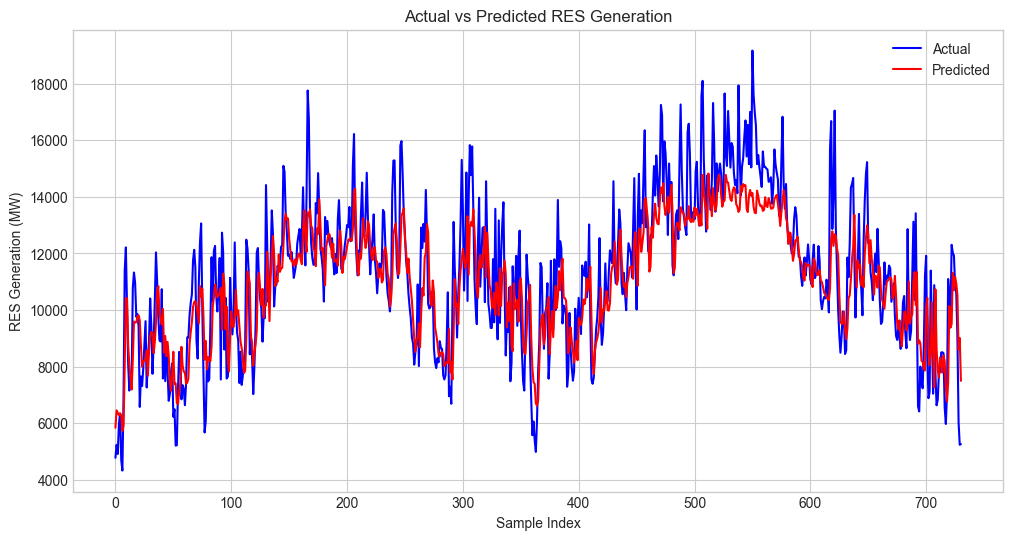

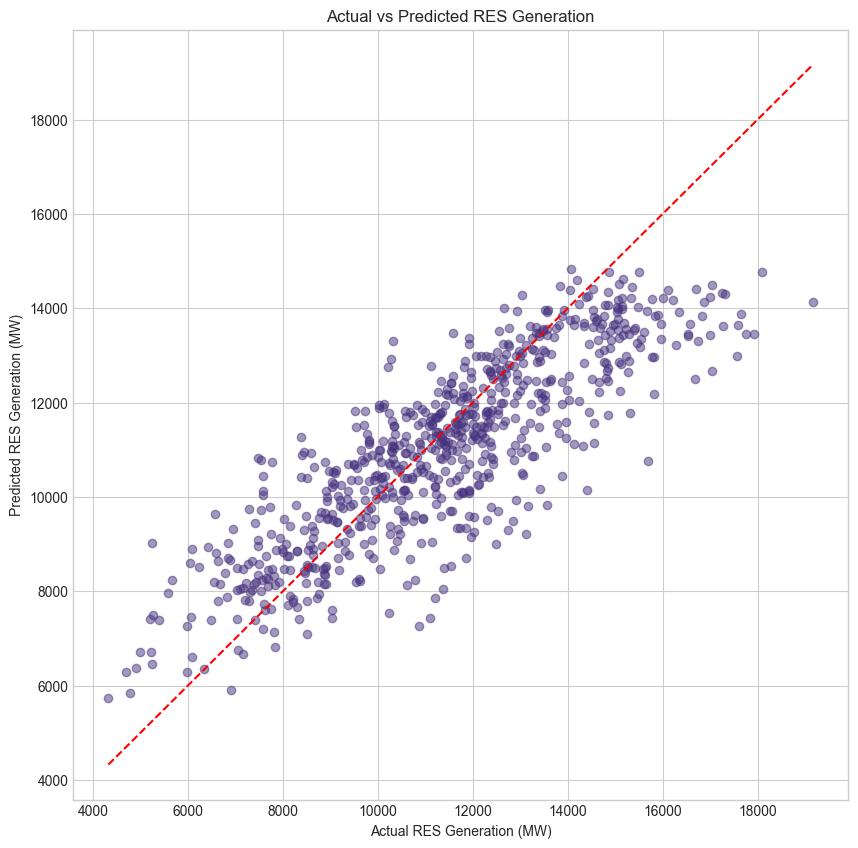

<Figure size 1200x800 with 0 Axes>

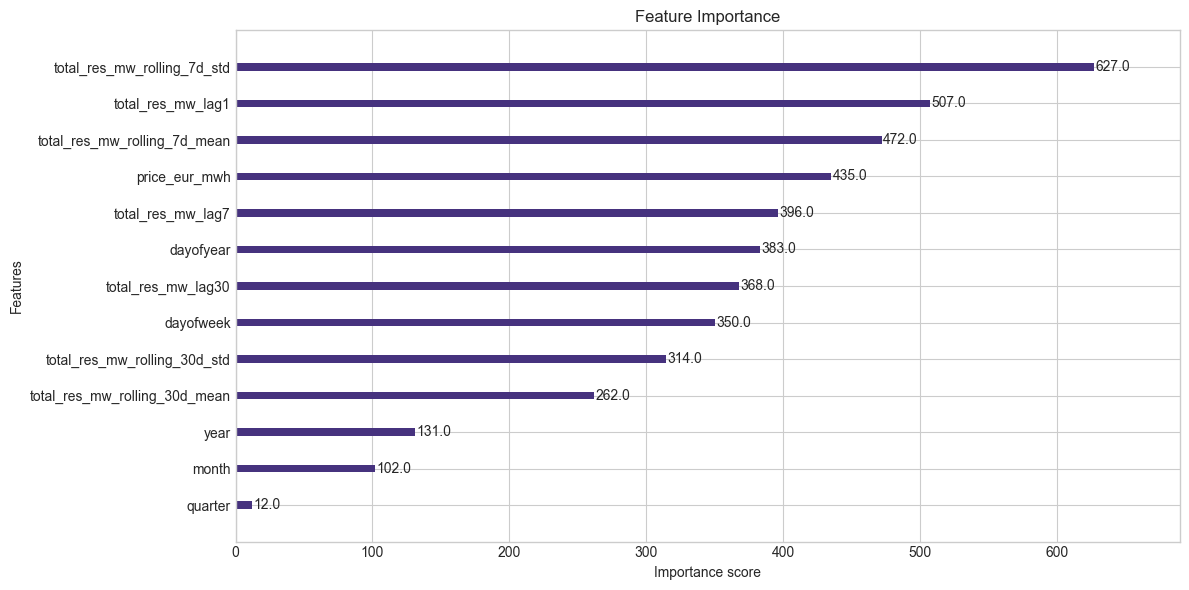

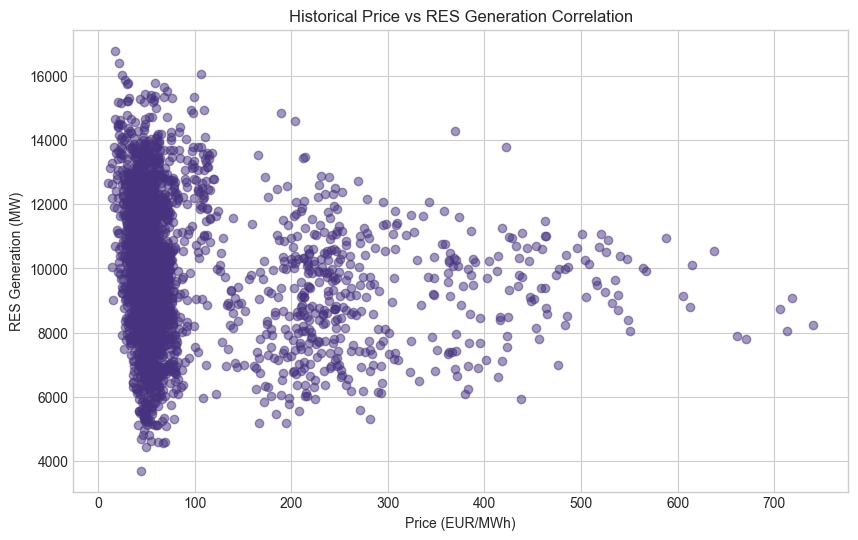

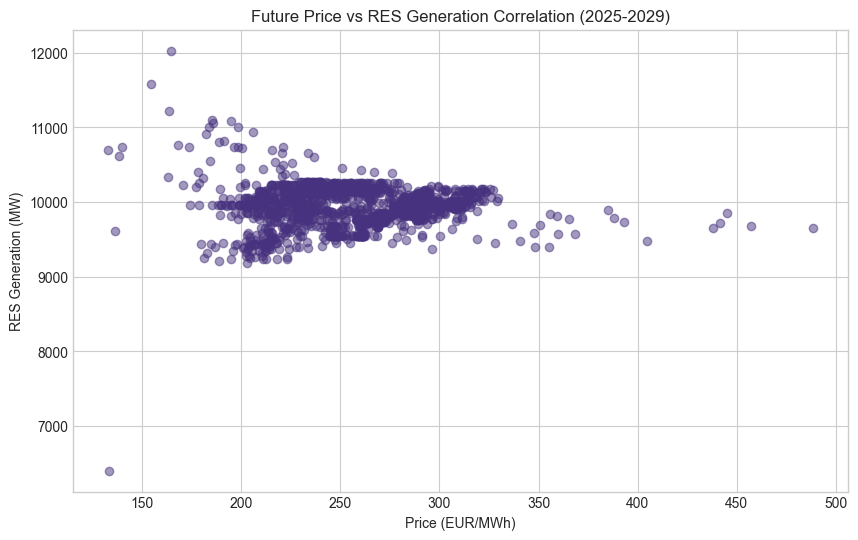

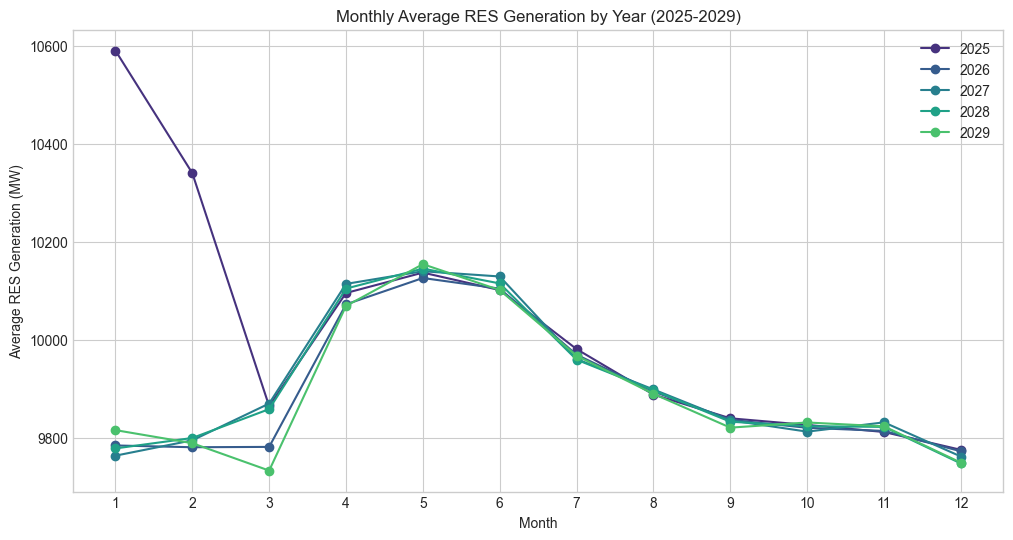

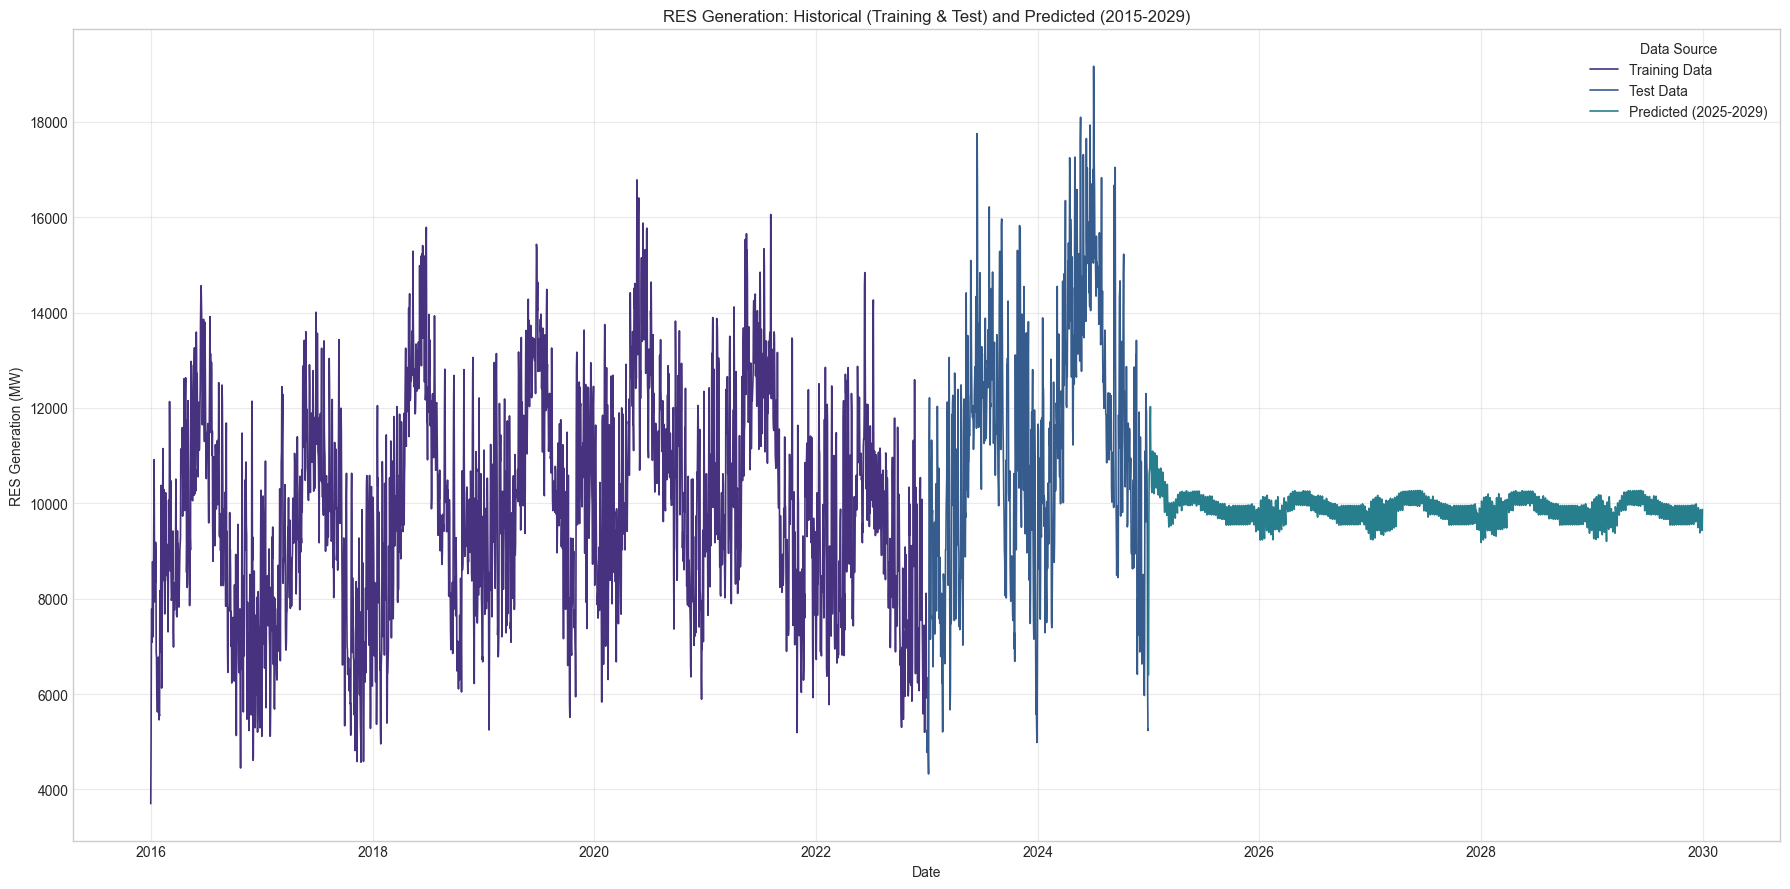

In [54]:
"""Main function to run the model training process"""
print("Starting RES Generation Forecasting Model Training...")

# Load data
train_data, test_data = load_data()

# Prepare features and target
X_train, y_train, X_test, y_test, features = prepare_features_target(train_data, test_data)

# Train model
model = train_model(X_train, y_train, X_test, y_test)

# Evaluate model
evaluate_model(model, X_test, y_test, features)

# Load price forecasts
price_forecasts = load_price_forecasts()

# Generate future predictions
future_predictions = generate_future_predictions(model, features, price_forecasts)

# Analyze correlations
if future_predictions is not None:
    analyze_correlations(train_data, future_predictions)
    plot_full_res_history_and_predictions(train_data, test_data, future_predictions)

print("RES Generation Forecasting Model Training completed successfully!")

## Conclusion

This notebook has successfully:
1. Loaded and preprocessed RES generation data
2. Created time-based features and lag features
3. Trained an XGBoost model for RES generation forecasting
4. Evaluated the model performance with metrics and visualizations
5. Generated future predictions for 2025-2029

The saved model can be used for forecasting RES generation in Italy for future energy market planning.